# TNM112 -- Lab 3

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_13 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1849

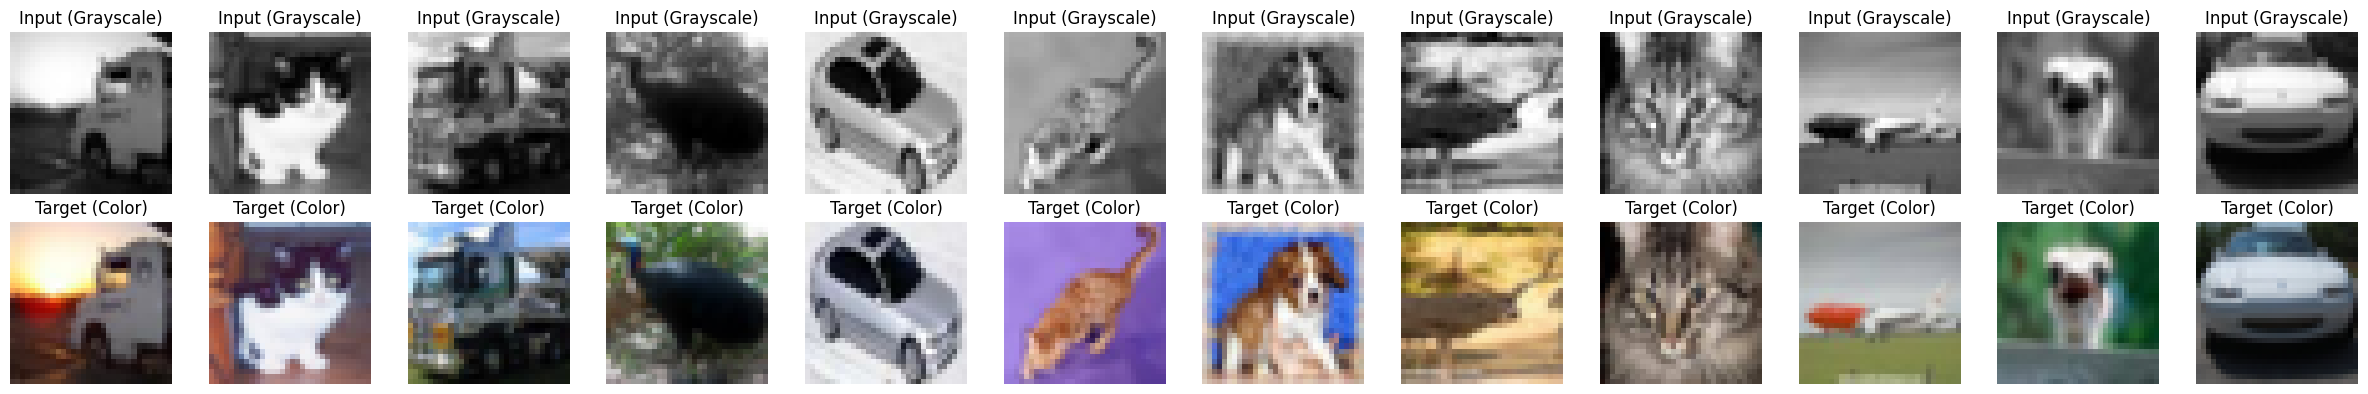

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 batch_normalization_22 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_23 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 64)        1849

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import util
import data_generator
import numpy as np
import matplotlib.pyplot as plt

def conv_block(x, N, channels, kernel_size, activation, padding='same', kernel_reg=None):
    for i in range(N):
        x = layers.Conv2D(channels, 
                          kernel_size=kernel_size, 
                          activation=activation, 
                          padding=padding,
                          kernel_regularizer=kernel_reg)(x)   
        x = layers.BatchNormalization()(x)
    return x  # No pooling here to preserve spatial dimensions

def colorization_cnn(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # First convolution block (Grayscale -> Feature extraction)
    x = conv_block(inputs, N=2, channels=32, kernel_size=(3, 3), activation='relu')
    
    # Second convolution block
    x = conv_block(x, N=2, channels=64, kernel_size=(3, 3), activation='relu')
    
    # Third convolution block
    x = conv_block(x, N=2, channels=128, kernel_size=(3, 3), activation='relu')

    x = conv_block(x, N=2, channels=264, kernel_size=(3, 3), activation='relu')

    x = conv_block(x, N=2, channels=512, kernel_size=(3, 3), activation='relu')

    # Final output layer to return to RGB channels (if desired)
    output = layers.Conv2D(3, kernel_size=(1, 1), activation='sigmoid', padding='same')(x)

    model = keras.models.Model(inputs, output)
    
    return model

epochs = 10
batch_size = 32
l2 = regularizers.L1L2(l1=1e-5, l2=1e-4) 

# Assuming grayscale input shape
input_shape = (32, 32, 1)  # Grayscale image
model = colorization_cnn(input_shape)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

# Initialize and prepare data
data = data_generator.DataGenerator()
# If subset, specify N_train=XXX
# 
data.generate(dataset='cifar10', N_valid=0.1)
data.plot()
 
input_shape = data.x_train_gray.shape[1:]  # Get the shape of the grayscale images

# Create the colorization model
model = colorization_cnn(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train the model
log = model.fit(data.x_train_gray, data.x_train, batch_size=batch_size, epochs=epochs,
                validation_data=(data.x_valid_gray, data.x_valid), validation_freq=1)

# Evaluate the model
util.evaluate(model, data)

# Visualize some predictions
sample_idx = np.random.randint(len(data.x_valid))
grayscale_input = data.x_valid_gray[sample_idx]
predicted_color = model.predict(np.expand_dims(grayscale_input, axis=0))[0]

# Plot original grayscale image and predicted colorized image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(grayscale_input.squeeze(), cmap='gray')
plt.title("Input (Grayscale)")

plt.subplot(1, 2, 2)
plt.imshow(predicted_color)
plt.title("Predicted (Colorized)")

plt.tight_layout()
plt.show()
